In [157]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os
import glob
import copy

from struct import unpack
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle
from itertools import permutations


import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time
big_filename = "F:\\0.Work\\BSA3_data\\011014_01_N1_00.pnthr"
filename = './data_pnt/230413_17_N1_00.pnt'
header = {}
with open(filename, 'rb') as F: #работает
    for i in range(16):
        line = F.readline()
        a, *b = line.decode("utf-8").strip('\n').split()
        header[a] = b  
        
    data = np.fromfile(F, dtype=np.float32)
    data = data.reshape((int(header['npoints'][0]), 6, 8, len(header['fbands']) + 1))

Wall time: 498 ms


In [5]:
print('npoints = ', len(data), '\n',
      'modules = ', len(data[0]), '\n',
      'rays = ', len(data[0][0]), '\n',
      'bands = ', len(data[0][0][0]))

npoints =  36019 
 modules =  6 
 rays =  8 
 bands =  7


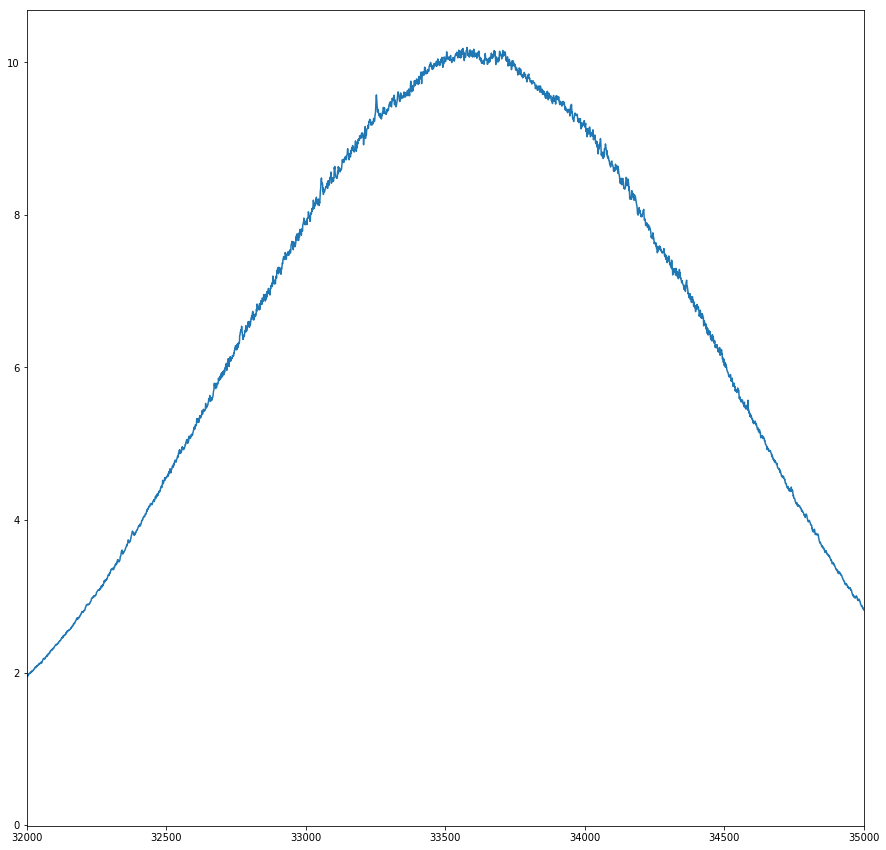

Wall time: 330 ms


In [33]:
%%time
module = 6
ray_1 = 7
#ray_2 = 8
chanel = 7

fig, ax = plt.subplots(figsize=(15, 15))

ax.plot([j[module-1][ray_1-1][chanel-1] for j in data])
#ax.plot([j[module-1][ray_2-1][chanel-1] for j in data])
plt.xlim(32000, 35000)
plt.show()

In [7]:
header

{'alpha': ['alpha'],
 'date_begin': ['23.04.2013'],
 'date_end': ['23.04.2013'],
 'delta': ['delta'],
 'fbands': ['109.20751953125',
  '109.62255859375',
  '110.03759765625',
  '110.45263671875',
  '110.86767578125',
  '111.28759765625'],
 'fcentral': ['110.25'],
 'modulus': ['1', '2', '3', '4', '5', '6'],
 'nbands': ['6'],
 'npoints': ['36019'],
 'numpar': ['16'],
 'source': ['source'],
 'time_begin': ['16:00:00'],
 'time_end': ['16:59:59'],
 'tresolution': ['99.9424'],
 'wb_total': ['2.5'],
 'wbands': ['0.4150390625',
  '0.4150390625',
  '0.4150390625',
  '0.4150390625',
  '0.4150390625',
  '0.4248046875']}

In [8]:
header['date_begin'][2]

IndexError: list index out of range

In [10]:
header['time_begin'][2]

'4:00:00'

In [34]:
if 'UTC' in header['date_begin']:
    day, month, year = header['date_begin'][2].split('.')
    hour, minute, second = header['time_begin'][2].split(':')
    isot_time = (year + '-' + month + '-' + day + 'T' +
                 hour + ':' + minute + ':' + second 
    )
    time = Time(isot_time, format='isot', scale='utc', precision=7)
else:
    day, month, year = header['date_begin'][0].split('.')
    hour, minute, second = header['time_begin'][0].split(':')
    isot_time = (year + '-' + month + '-' + day + 'T' +
                 hour + ':' + minute + ':' + second 
    )
    time = Time(isot_time, format='isot', scale='utc', precision=7)
    time -= 4*u.hour
# Определим прямое восхождение точки с номером 1050
time += 32860.9*float(header['tresolution'][0])*u.millisecond
t2000 = Time('2000-01-01T00:00:00', format='isot', scale='utc', precision=7)

In [35]:
print(time.jd)
print(t2000.jd)

2456406.0380115416
2451544.5


In [36]:
t = time.jd - t2000.jd - 1
t /= 36525

In [37]:
t

0.1330742782078464

In [38]:
s0 = 6 + 41 / 60.0 + 50.55 / 3600.0 + 8640184 / 3600.0 * t + 0.093104 / 3600.0 * t * t - 6.27 / 3600.0 * (1e-6) * t * t * t

In [39]:
s0

326.08244473103474

In [40]:
t_culm = (time.datetime.hour*u.hour 
          + time.datetime.minute*u.minute
          + time.datetime.second*u.second
          + time.datetime.microsecond*u.microsecond
)

In [41]:
t_culm

<Quantity 12.912277 h>

In [42]:
print(time.datetime.hour)
print(time.datetime.minute/60)
print(time.datetime.second/3600)
print(time.datetime.microsecond/3600/1000000)
print(time.datetime.hour + time.datetime.minute/60 + time.datetime.second/3600 + time.datetime.microsecond/3600/1000000)

12
0.9
0.012222222222222223
5.478111111111111e-05
12.912277003333333


In [43]:
alambda = 2 + 30/60.0 + 34/3600.0
cnst = 2.7379093e-3

In [44]:
s_culm = s0 + (cnst + 1) * t_culm.value + alambda

In [45]:
s_culm

341.5395188221041

In [46]:
delta_lucha = 0.89
print(delta_lucha)

0.89


In [47]:
fi = 0.956829
be = 0.008436
delt = delta_lucha
culm = s_culm
aa = ((np.sin(fi))**2) * ((np.cos(be))**2) + ((np.cos(fi))**2)
bb = 2 * np.sin(fi) * np.cos(be) * np.sin(delt)
cc = ((np.sin(delt))**2) - ((np.cos(fi))**2)

x = (bb + np.abs(bb) - 4 * aa * cc) / (2 * aa)
y = x * np.sin(be) / np.cos(delt)
z = np.sqrt(1 - y * y)

t = y / z
alf = culm * np.pi / 12 + np.arctan(t)

In [48]:
alf

89.42457369502682

In [49]:
rs = 4.8481368e-6
am = 46.1 * rs
an = 20.4 * rs

alfa1 = copy.copy(alf)
delta1 = copy.copy(delt)
alfa = copy.copy(alf)

for i in range(2):
    alf_res = alfa - (am + an * np.sin(alfa1) * np.tan(delta1)) * t
    delt_res = delt - an * np.cos(alfa1) * t
    alfa1 = (alf_res + alfa) / 2
    delta1 = (delt_res + delt) / 2

alf_res /= (15 * rs);
delt_res /= rs;

alf_res /= 3600;
while alf_res >= 24:
    alf_res -= 24

while alf_res < 0:
    alf_res += 24

print(Angle(alf_res*u.hourangle))
"""
if (realSeconds): {
    *realSeconds = alf_res * 3600;
}
"""
delt_res /= 3600;
while delt_res >= 360:
    delt_res -= 360

while delt_res < 0:
    delt_res += 360
print(Angle(delt_res*u.hourangle))

5h34m36.1144s
50h59m35.656s


In [31]:
m

[]

In [32]:
n

[]

In [202]:
delta_lucha

39.21

In [197]:
int(delt_res)

86

In [1]:
#just test that git from android is working